In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
from scipy.stats import norm, binom, mannwhitneyu, beta
from sklearn.preprocessing import normalize
from statsmodels.stats.power import tt_ind_solve_power

import pandahouse as ph


import time
from math import lgamma
from numba import jit
from tqdm.auto import tqdm
from itertools import product
from math import ceil
import re
import requests
from urllib.request import urlopen
from urllib.parse import urlencode
from io import BytesIO
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Задание 1. A/B–тестирование
<hr>

### 1.1 Условие

__Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.__

In [3]:
def get_zip_yandex_disk(public_key):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(url)
    download_link = response.json()['href']
    download_response = urlopen(download_link)
    zip_file = ZipFile(BytesIO(download_response.read()))
    file_names = list([x.filename for x in zip_file.infolist()])
    print(f'zip file contains {file_names}')   
    return zip_file


def density_distribution(data_column, plot_title:str, show_info=True, conf_level=0.95):
#   quantiles
    left_quant = (1 - conf_level)/2
    right_quant = 1 - (1 - conf_level)/2
    quants = data_column.quantile([left_quant, right_quant])

#   visualization
    if show_info is True:    
        plt.figure(figsize=(12, 5))
        fig_1 = plt.subplot(1, 2, 1)
        _, _, bars = plt.hist(data_column, bins = 30)
        for bar in bars:
            if bar.get_x() <= quants.iloc[0] or bar.get_x() >= quants.iloc[1]:
                bar.set_facecolor('red')
            else: 
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.style.use('seaborn-whitegrid')
        plt.vlines(quants,ymin=0,ymax=(len(data_column)*0.06),colors='red',linestyle='--')
        plt.vlines(data_column.mean(),ymin=0,ymax=(len(data_column)*0.06),colors='yellow',linestyle='--')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid(False)
        plt.title(f'{plot_title}\n')
        fig_2 = plt.subplot(1, 2, 2)
        ss.probplot(data_column, plot=plt)
        plt.title(f'{plot_title} QQ-plot\n')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid(False)
        plt.show()
    
#   Shapiro and D'Agostino normtest
    shapiro_result = ss.shapiro(data_column)
    dagostino_result = ss.normaltest(data_column)
    if ((shapiro_result[1] >= 0.05) & (dagostino_result[1] >= 0.05)):
        if show_info is True:
            print(f'{plot_title} has normal probability density distribution\n Shapiro test p-val {shapiro_result[1]}\n Dagostino p-val {dagostino_result[1]}' )
        return True
    else:
        if show_info is True:
            print(f'{plot_title} has not normal probability density distribution\n Shapiro test p-val {shapiro_result[1]}\n Dagostino p-val {dagostino_result[1]}')
        return False

    
# function to determine a sample size of nonparametric statistical test using the numeric Monte-Carlo method
def nonparam_sample_size(data_column, calculations=1000, alpha=0.05, lifts=np.arange(1, 1.02, 0.01), sizes=np.arange(500, 701, 200)):    

    res_df = pd.DataFrame() # calculation results are here

    for lift, n in tqdm(product(lifts, sizes)): 

        control = data_column.sample(n)

        # applying an effect
        test = control * lift 

        for _ in range(0, calculations):

            # A/B random grouping
            is_control = binom.rvs(1, 0.5, size=n) 

            # count p-value
            _, p = mannwhitneyu(control[is_control == True], test[is_control == False]) 

            # append result to df
            res_df = res_df.append({"lift": f'{int((lift-1.0)*100)}%', 
                                    "sample_size": n, "pvalue": p}, 
                                    ignore_index=True)

    result = res_df.groupby(["lift", "sample_size"]).apply(lambda x: sum(x['pvalue'] < alpha) / calculations)\
                   .to_frame().rename(columns={0: 'FPR/TPR'})
    return result 


@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
        den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
        h = np.exp(num - den)
        yield h / d

def g(a, b, c, d):
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a))) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

def bias_conv_test(imps_ctrl, convs_ctrl, imps_test, convs_test, linf=0, lsup=0.08, alpha=0.05):
    #here we create the Beta functions for the two sets
    alpha_ctrl, beta_ctrl = convs_ctrl+1, imps_ctrl-convs_ctrl+1
    beta_C = beta(alpha_ctrl, beta_ctrl)
    alpha_test, beta_test = convs_test+1, imps_test-convs_test+1
    beta_T = beta(alpha_test, beta_test)
    
    l_ctrl, r_ctrl = beta.ppf(alpha / 2, a=alpha_ctrl, b=beta_ctrl), beta.ppf(1 - alpha / 2, a=alpha_ctrl, b=beta_ctrl)
    l_test, r_test = beta.ppf(alpha / 2, a=alpha_test, b=beta_test), beta.ppf(1 - alpha / 2, a=alpha_test, b=beta_test)
    
    #calculating the lift
    lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

    #calculating the probability for Test to be better than Control
    prob=calc_prob_between(beta_T, beta_C)
    
    betas = [beta_C, beta_T]
    names = ['Control', 'Test']
    
    x=np.linspace(linf,lsup, 100)
    plt.figure(figsize=(10, 8))
    for f, name in zip(betas,names):
        y=f.pdf(x)                                    #this for calculate the value for the PDF at the specified x-points
        y_mode=(f.args[0]-1)/(f.args[0]+f.args[1]-2)
        y_var=f.var()                                 # the variance of the Beta distribution
        plt.plot(x,y, label=f"{name} sample, conversion rate: {y_mode:0.1E} $\pm$ {y_var:0.1E}")
        plt.vlines(f.mean(),ymin=0,ymax=y.max(), colors='r',linestyle='--')
        plt.yticks([])
    plt.legend()
    plt.show()

    print (f"Область наибольшей апостериорной плотности для группы А {[round(l_ctrl, 4), round(r_ctrl, 4)]}\n"
           f"Область наибольшей апостериорной плотности для группы B {[round(l_test, 4), round(r_test, 4)]}\n"
           f"Изменение целевой статистики группы B относительно А {lift*100:2.2f}% с вероятностью {prob*100:2.1f}%.")

In [4]:
karpov_zip = get_zip_yandex_disk('https://disk.yandex.ru/d/U4md-w8xJ5zlPQ')

zip file contains ['active_studs.csv', 'checks.csv', 'group_add.csv', 'groups.csv']


In [5]:
groups = pd.read_csv(karpov_zip.open('groups.csv'), sep=';')
# groups_add = pd.read_csv(karpov_zip.open('group_add.csv'), sep=',')
active_studs = pd.read_csv(karpov_zip.open('active_studs.csv'))
checks = pd.read_csv(karpov_zip.open('checks.csv'), sep=';')

In [6]:
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [7]:
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [8]:
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [9]:
active_studs = active_studs.rename(columns={'student_id': 'id'})
checks = checks.rename(columns={'student_id': 'id'})

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?

__По хорошему, сначала нужно было выбрать критерии эксперимента, а потом его проводить. Ну предположим, что нас интересует, есть ли статистически достоверная разница между группами в показателях:__

* __Средняя стоимость заказа__

* __Доход от посетителя (ARPU)__

* __Коэффициент конверсии из посетителя в покупателя (сколько пользователей из тех, что зашли на сайт, совершили покупку)__

__Уровень значимости 0.95, мощность теста 0.8, MDE = 5%__

In [10]:
groups = groups.merge(active_studs, on='id', how='right')\
               .merge(checks, on='id', how='left')\
               .fillna(0).reset_index(drop=True)
groups = groups[groups.grp != 0]

In [11]:
(groups.grp.value_counts() / groups.grp.count()) * 100

B    81.568204
A    18.431796
Name: grp, dtype: float64

__Группы поделенны неравномерно, глянем на график распределения плотности вероятности, чтобы выяснить его характер.__

In [12]:
A = groups[groups.grp == 'A'].reset_index(drop=True)
B = groups[groups.grp == 'B'].reset_index(drop=True)

# добавим колонку с индикатором конверсии
A['purchase'] = np.select([(A.rev == 0.0), (A.rev != 0.0)], [0, 1])
B['purchase'] = np.select([(B.rev == 0.0), (B.rev != 0.0)], [0, 1])

# проверим, что пользователи в группах не пересекаются
B.merge(A, on='id').shape[0] == 0

True

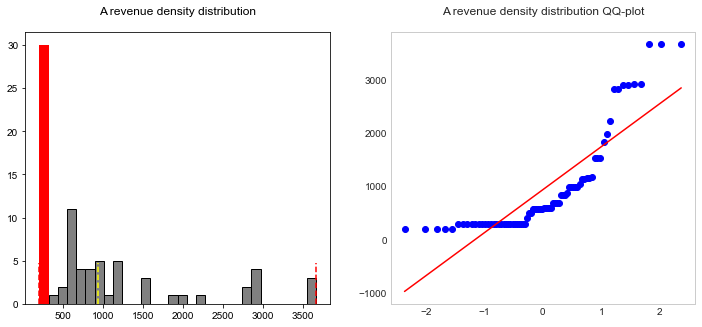

A revenue density distribution has not normal probability density distribution
 Shapiro test p-val 1.4986822893803264e-10
 Dagostino p-val 2.531686880422046e-07


False

In [13]:
density_distribution(A[A.rev != 0.0].rev, plot_title='A revenue density distribution')

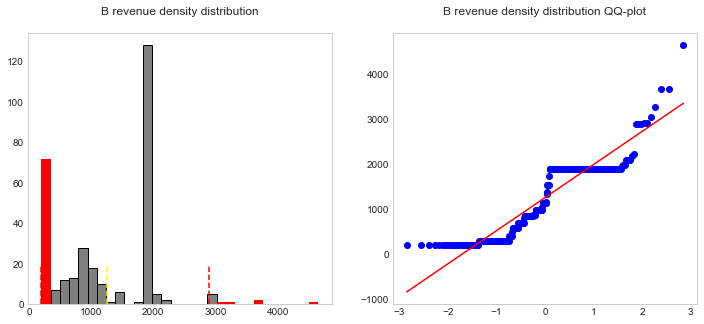

B revenue density distribution has not normal probability density distribution
 Shapiro test p-val 1.756778758085431e-16
 Dagostino p-val 0.029863005181946005


False

In [14]:
density_distribution(B[B.rev != 0.0].rev, plot_title='B revenue density distribution')

In [15]:
print(f'В группе B {B[B.rev != 0.0].rev.shape[0]} пользователей совершили покупку\n'
      f'В группе A {A[A.rev != 0.0].rev.shape[0]} пользователей совершили покупку')

В группе B 313 пользователей совершили покупку
В группе A 78 пользователей совершили покупку


__Выборки, судя по результатам теста на нормальность, вынуты из популяций(или одной популяции) с ненормальным распределением величины выручки с чека. При таком дисбалансе в делении на группы итак существуют проблемы с мощностью теста (при достаточно большой выборке этим можно пренебречь), а тут еще и размеры выборок весьма невелики. Проведем синтетический тест, чтобы выяснить, какой эффект тут можно задетектировать при выбранных параметрах эксперимента. В качестве размера выборки для синтетического эксперимента выберем меньший (78)__ 

In [16]:
sample_size = nonparam_sample_size(data_column=A[A.rev != 0.0].rev, 
                                   lifts=np.arange(1.00, 1.09, 0.01), 
                                   sizes=[78])

0it [00:00, ?it/s]

In [17]:
sample_size

,,FPR/TPR
lift,sample_size,
0%,78,0.049
1%,78,0.144
2%,78,0.159
3%,78,0.183
4%,78,0.188
5%,78,0.173
6%,78,0.194
7%,78,0.201
8%,78,0.159


__При таком дизайне эксперимента вообще нельзя сравнивать контрольную и тестовую группы. С имеющимися данными невозможно достоверно задетектировать наличие разницы. Мощность теста при размере выборки 78 пользователей не достигает и 0.2 при установленном уровне на этапе дизайна 0.8. Вероятность ошибки II рода слишком велика, так что сравнивать денежные метрики нельзя.__

__Но зато можно провести сравнение конверсий. Чем и займемся__

__Есть данные о 1538 пользователе в группе А и 6803 в группе B. Размер выборки, опять же, увеличить невозможно, есть уже только готовые данные, но при таком размере групп вариация признака вокруг истинного значения CR будет приемлемой. CR распределен по биномиальному закону, для сравнения лучше всего использовать Байесовский подход. В качестве априорного распределения примем бета-распределение с параметрами альфа и бета, посчитанными исходя из значений наблюдаемой частоты конверсии. Код фнукции выше, реализация ниже.__ 

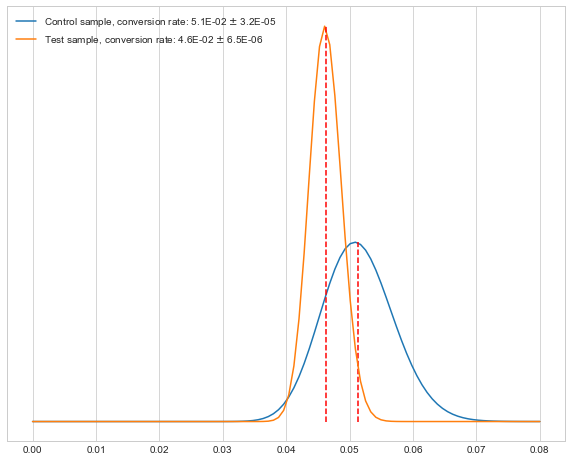

Область наибольшей апостериорной плотности для группы А [0.0409, 0.063]
Область наибольшей апостериорной плотности для группы B [0.0413, 0.0513]
Изменение целевой статистики группы B относительно А -10.09% с вероятностью 20.2%.


In [18]:
imps_ctrl,convs_ctrl=A.id.count(), A.purchase.sum() 
imps_test, convs_test=B.id.count(), B.purchase.sum()

bias_conv_test(imps_ctrl=imps_ctrl,
               convs_ctrl=convs_ctrl,
               imps_test=imps_test,
               convs_test=convs_test)

__Как видим, CR для группы B оказался ниже, чем для группы A на 9,76% с вероятностью 21%. Область наибольшей апостериорной плотности для группы А полностью перекрывает Область наибольшей апостериорной плотности для группы B. Интервал конверсии, в который с 95% вероятностью попадает реальный коэффициент конверсии полностью перекрыватся таким интервалом для группы А.__

__Говоря простыми словами, нельзя отвергнуть нулевую гипотезу о том, что конверсии значимо различаются, к тому же, можно утверждать с вероятностью 21%, что полученные для групп результаты говорят о снижении конверсии для группы В на 9,76%. Изменения в продакшн не катить!!!!!__

<hr>

# Задание 2. SQL
<hr>

### 2.1 Очень усердные ученики.

### 2.1.1 Условие

__Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".__

__Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.__

In [19]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [20]:
opt_query = """
SELECT      month_year,
            COUNT(DISTINCT(st_id)) as number_of_stud
FROM        (
            SELECT      st_id,
                        toStartOfMonth(timest) as month_year,
                        SUM(correct) as sum_correct
            FROM        default.peas
            GROUP BY    st_id,
                        month_year,
                        subject
            HAVING      sum_correct >= 20
            )

GROUP BY    month_year
"""

opt_q = ph.read_clickhouse(query=opt_query, connection=connection_default)
opt_q

,month_year,number_of_stud
0,2021-10-01,78


### 2.2 Оптимизация воронки

### 2.2.1 Условие

__Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.__




__Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:__

* __ARPU__ 
* __ARPAU__ 
* __CR в покупку__ 
* __СR активного пользователя в покупку__ 
* __CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике__


__ARPU считается относительно всех пользователей, попавших в группы.__

__Активным считается пользователь, за все время решивший больше 10 задач правильно в _любых_ дисциплинах.__

__Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по _математике_.__

In [21]:
QUERY = """
SELECT          test_grp,
                SUM(money) / COUNT(DISTINCT(st_id)) as ARPU,
                COALESCE(SUM(money), 0) / SUM(active) AS ARPAU,
                COUNT(DISTINCT(proj_check.st_id)) / COUNT(DISTINCT(st_id)) as CR,
                COUNT(DISTINCT(proj_check.st_id))/ COUNT(DISTINCT(active_users.st_id)) as CR_active,
                SUM(CASE WHEN active_math = 1 AND purchase_math = 1 THEN 1 ELSE 0 END)::float / SUM(active_math) AS CR_math
FROM
(SELECT          *
FROM            (SELECT          *
                FROM            default.studs as studs
                LEFT JOIN       (
                                SELECT      st_id,
                                            SUM(money) as money,
                                            MAX(CASE WHEN subject = 'Math' THEN 1 ELSE 0 END) AS purchase_math
                                FROM        default.final_project_check
                                GROUP BY    st_id
                                ) as proj_check
                ON              studs.st_id = proj_check.st_id ) as all_users

LEFT JOIN       (SELECT         DISTINCT(st_id),
                                1 as active,
                                SUM(correct) as sum_correct
                FROM            default.peas as peas
                GROUP BY        st_id,
                                subject
                HAVING          sum_correct > 10) as active_users
ON              all_users.st_id = active_users.st_id) as l

LEFT JOIN       (SELECT         DISTINCT(st_id),
                                1 as active_math,
                                SUM(correct) as sum_correct
                FROM            default.peas as peas
                WHERE           subject = 'Math'
                GROUP BY        st_id
                HAVING          sum_correct >= 2) as r
ON              l.st_id = r.st_id

GROUP BY        test_grp
"""

summarize_metrics = ph.read_clickhouse(query=QUERY, connection=connection_default)
summarize_metrics

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math
0,control,5278.688525,10320.512821,0.052459,0.134454,0.042857
1,pilot,14881.355932,33007.518797,0.111864,0.358696,0.111111


<hr>

# Задание 3. Python

<hr>

__3.1 Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.__

__3.2 Реализуйте функцию, которая будет строить графики по получаемым метрикам.__

In [22]:
def get_metrics(df):
    
    df['purchase'] = np.select([(df.rev == 0.0), (df.rev != 0.0)], [0, 1])
    
    res_df = df.groupby('grp', as_index=False)\
               .agg({'id': 'count'})\
               .rename(columns={'id': 'sample_size'})
    res_df['CR'] =(df.groupby('grp', as_index=False).agg({'purchase': 'sum'})['purchase'] / res_df['sample_size']).round(4)
    res_df['ARPU'] =(df.groupby('grp', as_index=False).agg({'rev': 'sum'})['rev'] / res_df['sample_size']).round(2)
    res_df['mean_check'] = (df[df.rev != 0.0].groupby('grp', as_index=False).agg({'rev': 'sum'})['rev'] 
                            / df[df.rev != 0.0].groupby('grp', as_index=False).agg({'id': 'count'})['id']).round(3)
    
    return res_df

def refresh_data(public_key, df, resulting_df):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(url)
    download_link = response.json()['href']
    download_response = urlopen(download_link)
    add_data = BytesIO(download_response.read())
    groups_add = pd.read_csv(add_data, sep=',', names=['id', 'grp'], header=0)
    
    df = pd.concat([df, groups_add])\
           .merge(active_studs, on='id', how='right')\
           .merge(checks, on='id', how='left')\
           .fillna(0).drop(columns='rev_y')\
           .rename(columns={'rev_x': 'rev'})\
           .drop_duplicates(subset='id')\
           .reset_index(drop=True)
    df = df[df.grp != 0]
    
    res_df = get_metrics(df)
    resulting_df = pd.concat([resulting_df, res_df]).reset_index(drop=True)
        
    return df, resulting_df


def plot_metrics(resulting_df):
    
    plt.figure(figsize=(15, 9))
    group_index = ['A', 'B']
    
    for indx in group_index:
        df_grp = resulting_df[resulting_df.grp == indx]
        plt.figure(figsize=(15, 9))
        data_columns = ['CR', 'ARPU', 'mean_check']
        
        for i, col in enumerate(data_columns):
            i += 1
            data_column = df_grp[col]
            ax = plt.subplot(3 , 3, i)
            plot_title = '\n' + col.replace('_', ' ') + f' group {indx}'
            sns.lineplot(df_grp.sample_size, data_column)
            plt.style.use('seaborn-whitegrid')
            plt.title(plot_title)
    
    plt.show()
    

__Реализовал функцию построения графиков в виде: для каждой метрики каждой группы свой график, потому что на общем, в связи с малыми изменениями метрики, ничего не видно__

In [23]:
# первичный сводный датафрейм с метриками
metrics_data = get_metrics(groups)

# дополняем и обновляем инфу по метрикам
groups, metrics_data = refresh_data('https://disk.yandex.ru/d/NXlW0az7M4KqIQ', groups, metrics_data)

In [24]:
metrics_data

,grp,sample_size,CR,ARPU,mean_check
0,A,1535,0.0508,47.44,933.590
1,B,6793,0.0461,57.86,1255.827
2,A,1538,0.0507,47.35,933.590
3,B,6803,0.0460,57.78,1255.827


<Figure size 1080x648 with 0 Axes>

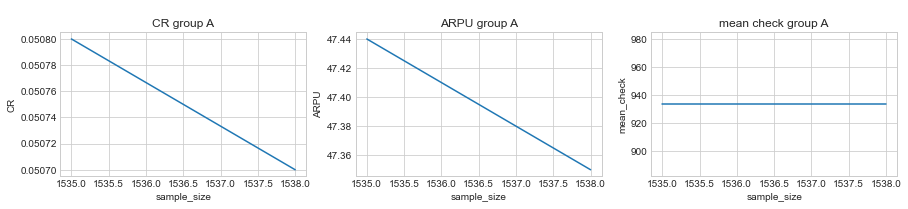

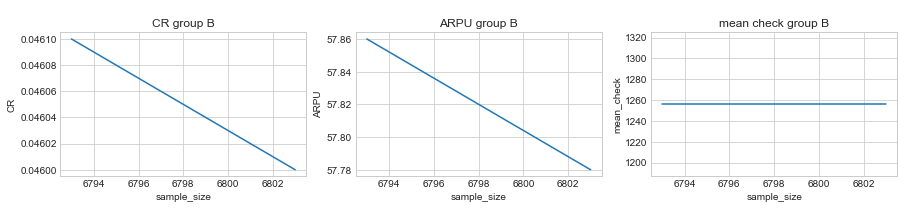

In [25]:
plot_metrics(metrics_data)